## update from V4 to V5

### add more inputs to model, focus on Random Forest model

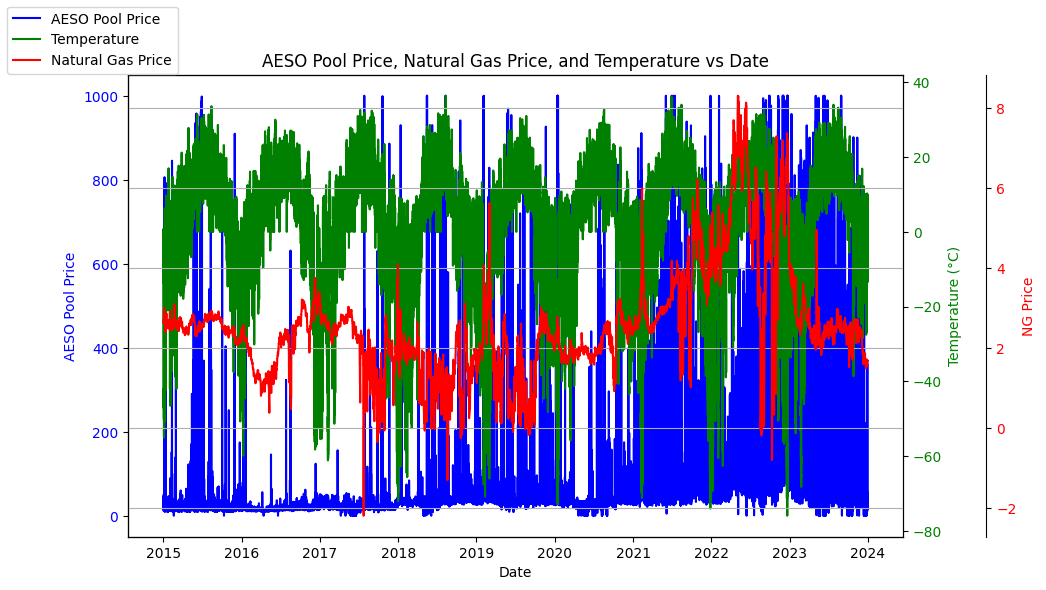

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('Merged Data.csv', parse_dates=['Date'])

# Create a single plot with separate y-axes for temperature and NG price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Pool Price
ax1.plot(data['Date'], data['AESO Pool Price CAD/MWh'], label='AESO Pool Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('AESO Pool Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['Temp Calgary deg C'], label='Temperature', color='green')
ax2.set_ylabel('Temperature (°C)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis for the NG price
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
ax3.plot(data['Date'], data['AECO 2A CAD/GJ'], label='Natural Gas Price', color='red')
ax3.set_ylabel('NG Price', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a legend with custom handles
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc='upper left')

plt.title("AESO Pool Price, Natural Gas Price, and Temperature vs Date")
plt.grid(True)
plt.show()

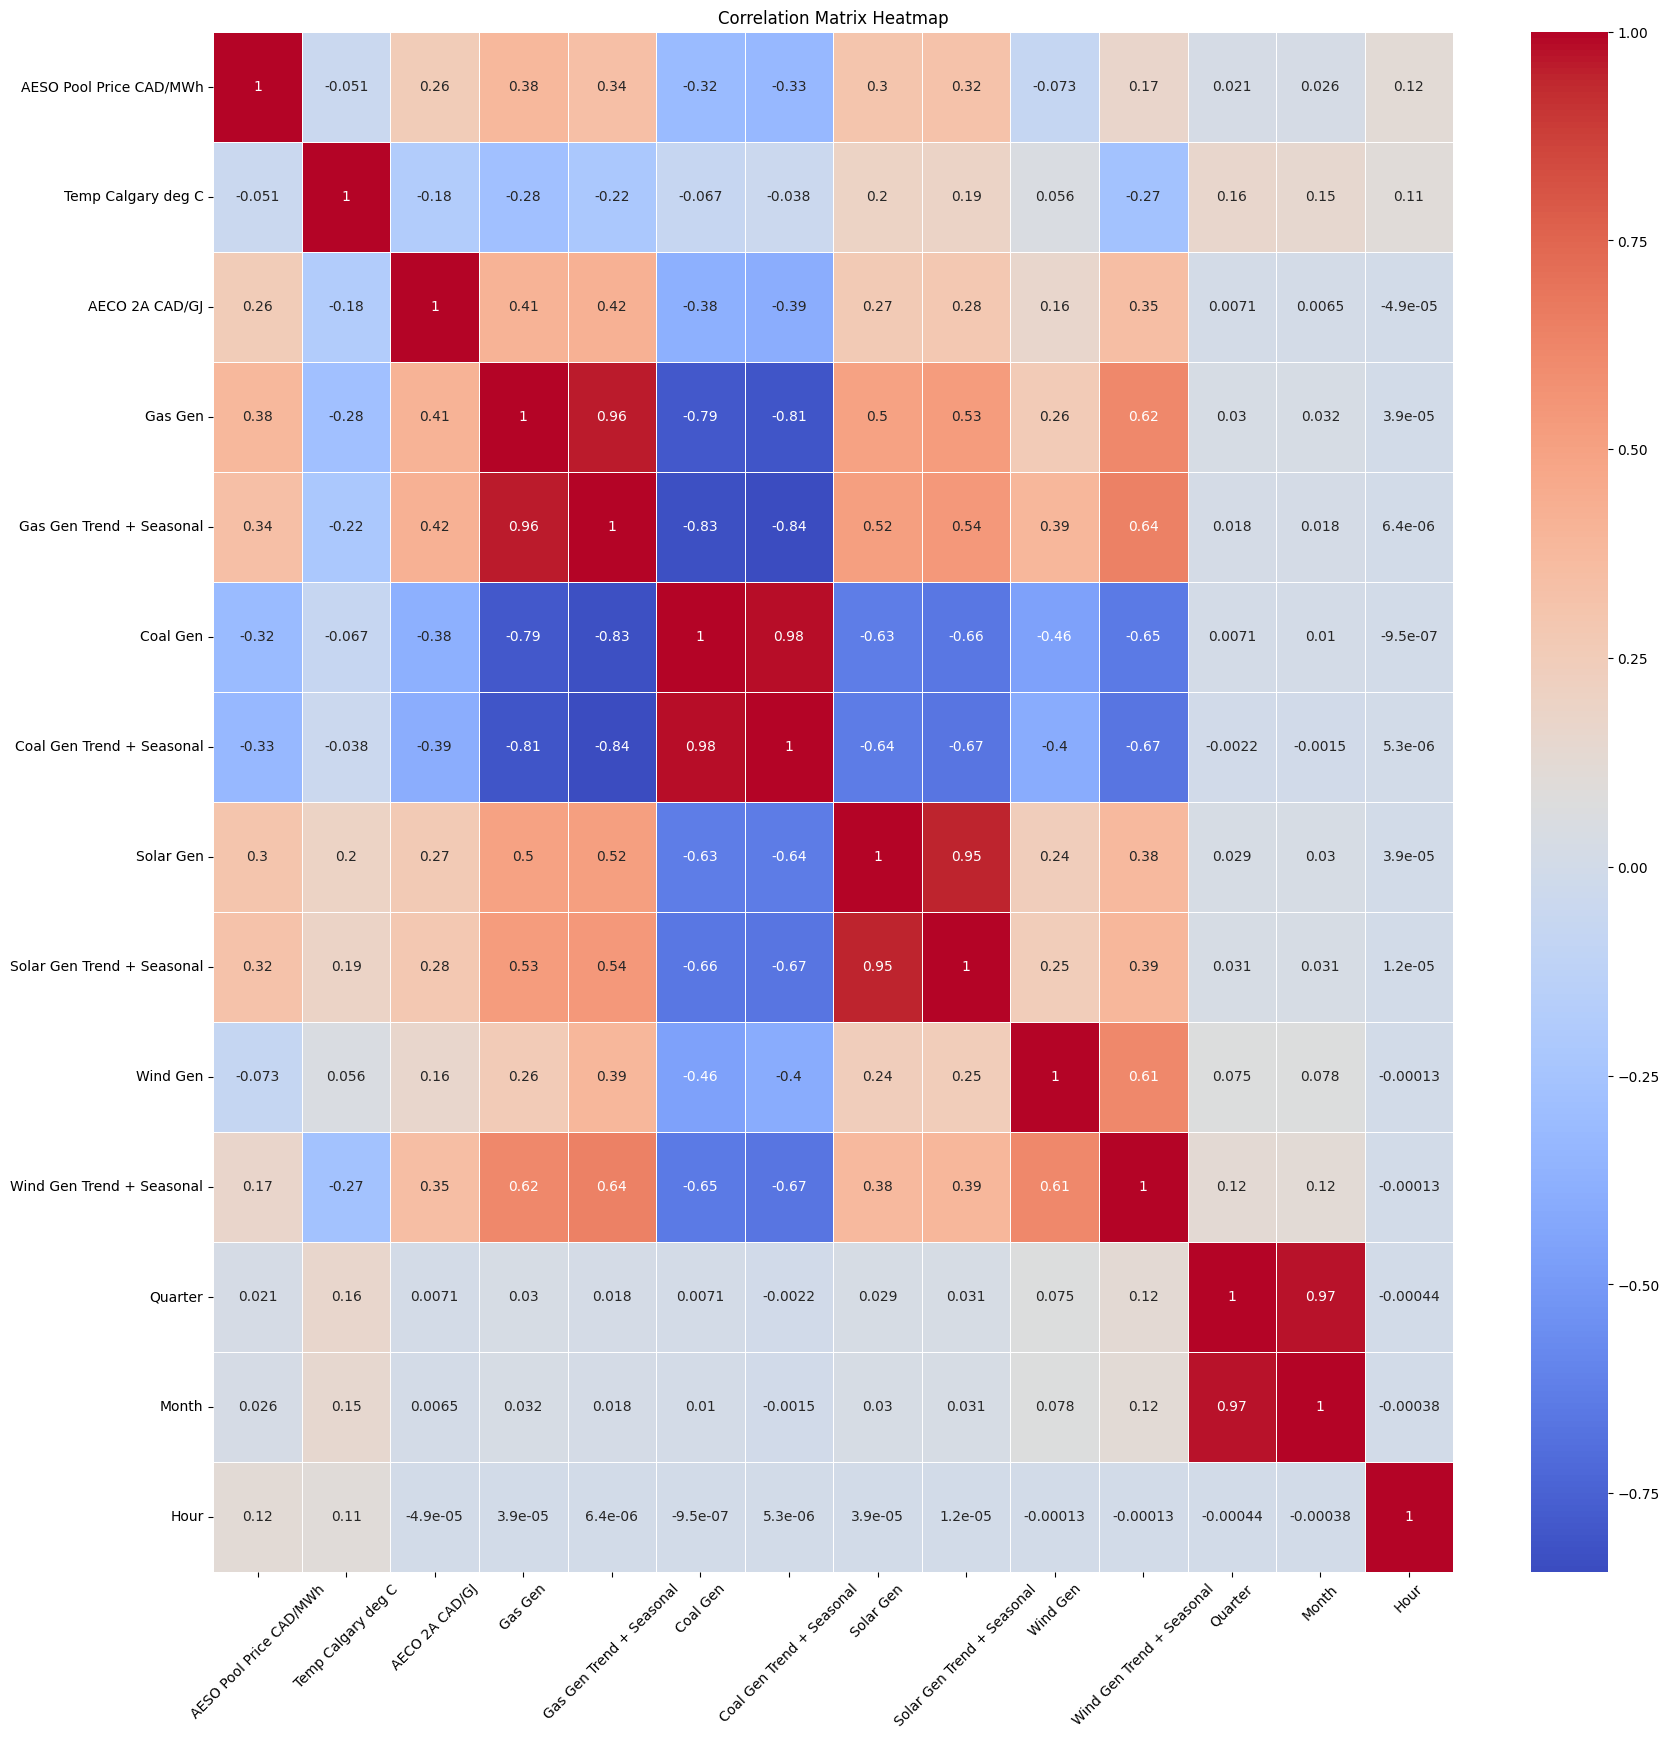

In [3]:
data_numeric = data.drop(['Date','Date Daily'], axis=1)

correlation_matrix = data_numeric.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot (optional)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [4]:
data.head()

,Date,AESO Pool Price CAD/MWh,Date Daily,Temp Calgary deg C,AECO 2A CAD/GJ,Gas Gen,Gas Gen Trend + Seasonal,Coal Gen,Coal Gen Trend + Seasonal,Solar Gen,Solar Gen Trend + Seasonal,Wind Gen,Wind Gen Trend + Seasonal,Quarter,Month,Hour
0,2015-01-01 00:00:00,37.45,2015-01-01,-13.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,0
1,2015-01-01 01:00:00,34.62,2015-01-01,-2.5,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,1
2,2015-01-01 02:00:00,22.80,2015-01-01,-6.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,2
3,2015-01-01 03:00:00,21.05,2015-01-01,-7.6,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,3
4,2015-01-01 04:00:00,20.79,2015-01-01,-6.7,2.631,87172.18642,130165.3482,0.0,0.0,0.0,0.0,16123.84593,34653.46934,1,1,4


## Random Forest Regression Model - Random split data

Temp Calgary deg C: 0.4242
AECO 2A CAD/GJ: 0.0539
Coal Gen: 0.1652
Gas Gen: 0.3525
Solar Gen: 0.1279
Wind Gen: 0.2304
Random Forest Mean Squared Error: 8276.316635547357
Random Forest R-squared: 0.5027435431854367


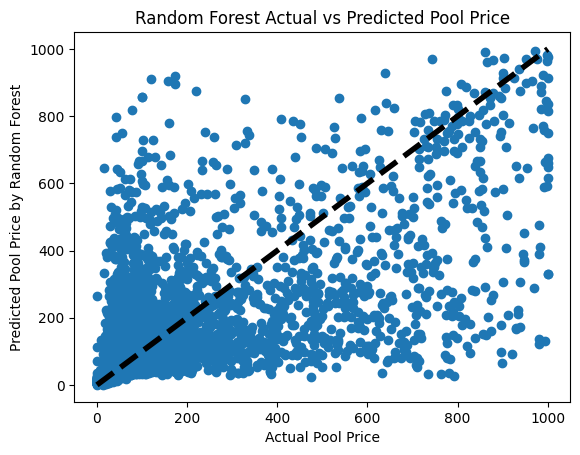

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score  # Importing the mean_squared_error function
from sklearn.impute import SimpleImputer

# Sort the data by date
df = data.sort_values(by='Date')

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

## Random Forest Regression Model - split data with train 2015-2021, test 2022-2023

Temp Calgary deg C: 0.1794
AECO 2A CAD/GJ: -0.0227
Coal Gen: -0.0014
Gas Gen: -0.0031
Solar Gen: 0.0074
Wind Gen: 0.0690
Random Forest Mean Squared Error: 32658.01040398835
Random Forest R-squared: 0.11603405691301849


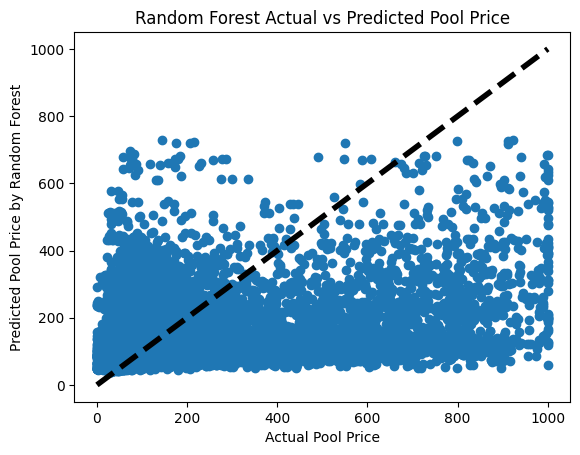

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


# Sort the data by date
df = data.sort_values(by='Date')

# Define date ranges
start_date_1 = pd.Timestamp('2015-01-01 00:00:00')
end_date_1 = pd.Timestamp('2021-12-31 23:00:00')
start_date_2 = pd.Timestamp('2022-01-01 00:00:00')
end_date_2 = pd.Timestamp('2023-12-31 23:00:00')

# Create masks for slicing
mask_train = (df['Date'] >= start_date_1) & (df['Date'] <= end_date_1)
mask_test = (df['Date'] >= start_date_2) & (df['Date'] <= end_date_2)

# Create training and test datasets
train_data = df[mask_train]
test_data = df[mask_test]

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(train_data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])

# Preparing the data for modeling
X_train = pd.DataFrame(X_imputed, columns=['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen'])  # independent variables
y_train = train_data['AESO Pool Price CAD/MWh'].dropna()  # dependent variable
X_test_imputed = imputer.fit_transform(test_data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']])
X_test = pd.DataFrame(X_test_imputed, columns=['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen'])  # independent variables
y_test = test_data['AESO Pool Price CAD/MWh'].dropna()  # dependent variable

# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

## Random Forest Regression model with X_test.index 

Mean Squared Error: 8058.94
Root Mean Squared Error: 89.77
R-squared: 0.51


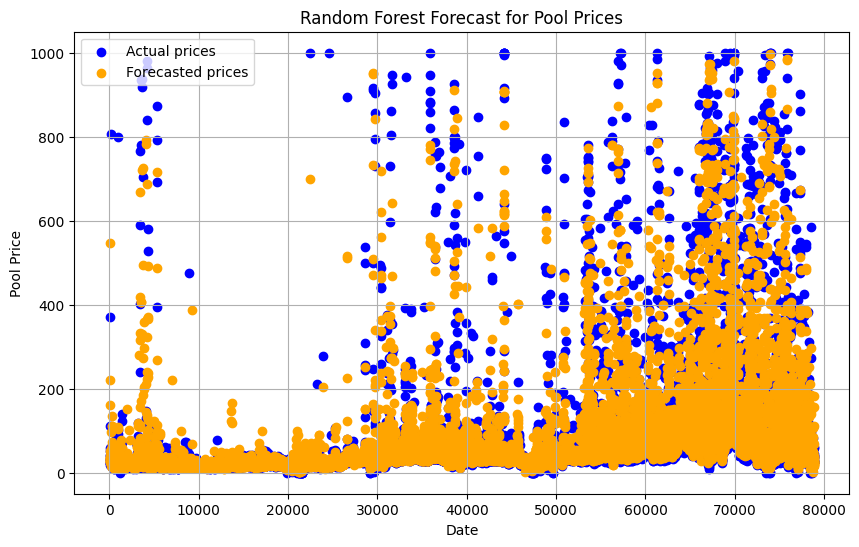

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict future prices
y_pred = model.predict(X_test)

# Evaluate the model (MSE and RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# R-squared (Coefficient of Determination)
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2:.2f}")

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, label='Actual prices', color='blue')
plt.scatter(X_test.index, y_pred, label='Forecasted prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Pool Price')
plt.title('Random Forest Forecast for Pool Prices')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost model with SHAP, random_state=42

c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 98%|===================| 15522/15778 [00:32<00:00]        

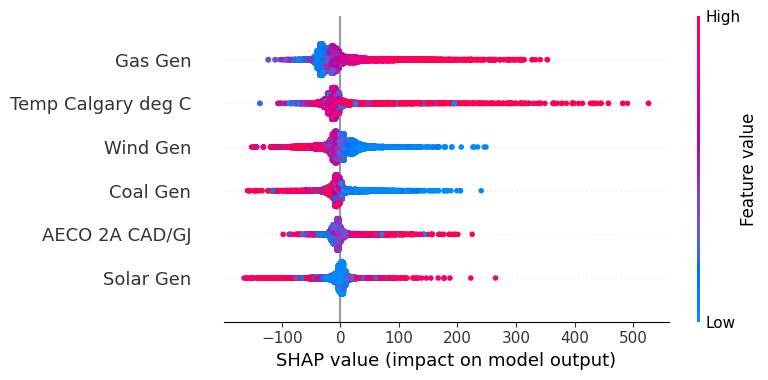

In [8]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Visualize feature importance (e.g., summary plot)
feature_names = X_test.columns.tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

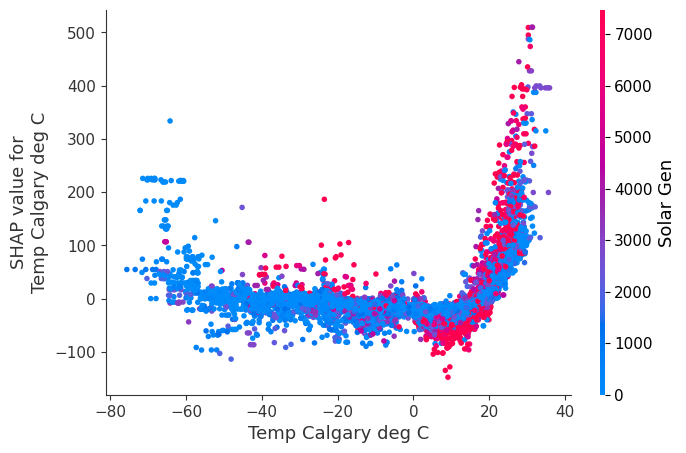

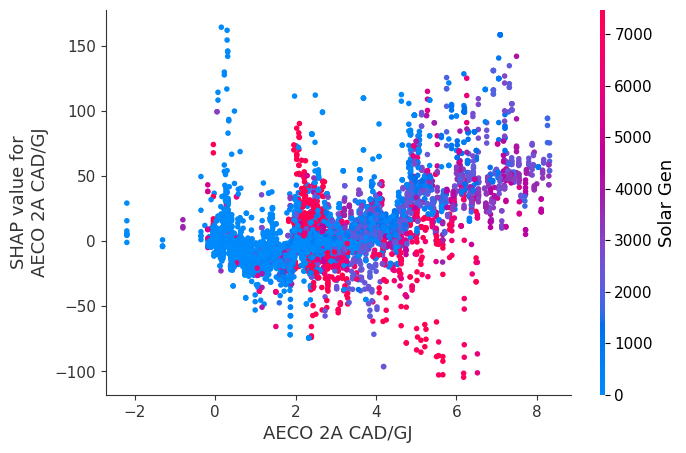

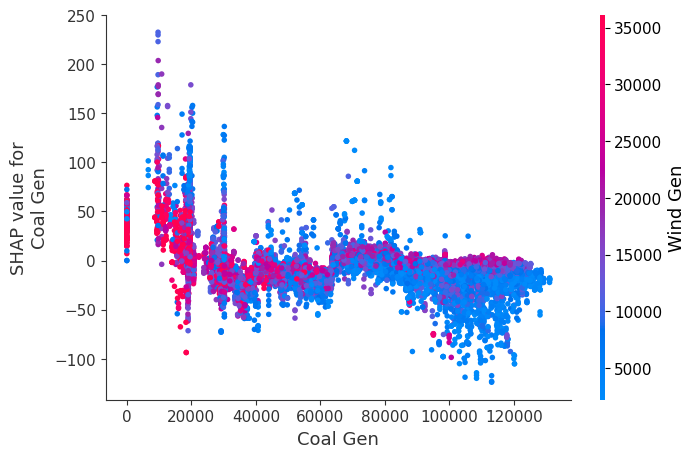

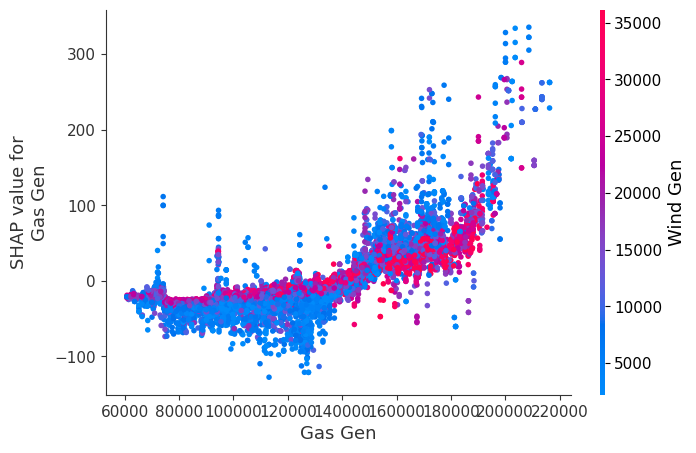

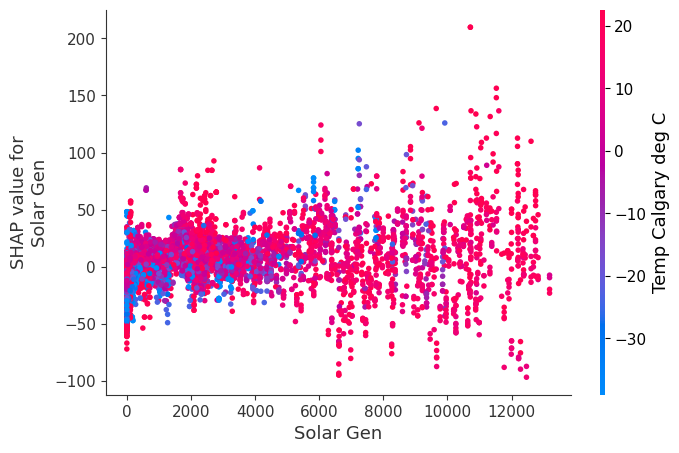

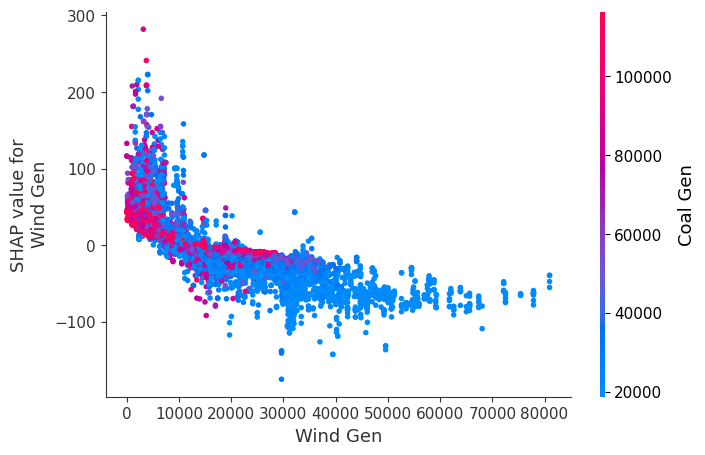

In [10]:
shap.dependence_plot(0, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(1, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(2, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(3, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(4, shap_values, X_test, feature_names=feature_names)
shap.dependence_plot(5, shap_values, X_test, feature_names=feature_names)

## XGBoost model with SHAP, Random_state=0

 98%|===================| 15475/15778 [00:32<00:00]        

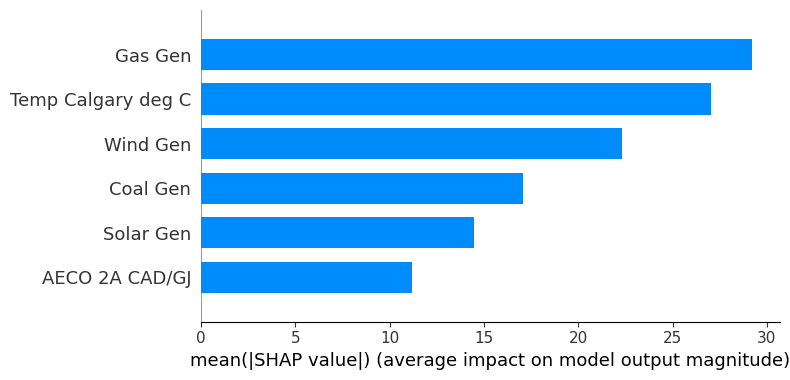

In [9]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp Calgary deg C', 'AECO 2A CAD/GJ', 'Coal Gen', 'Gas Gen', 'Solar Gen', 'Wind Gen']]  # independent variables
y = data['AESO Pool Price CAD/MWh']  # dependent variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Visualize feature importance (e.g., summary plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
